# MNIST
with pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:

tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('./data', download=True, train=True, transform=tr)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
print(train_data)

test_data = datasets.MNIST('./data', train=False, transform=tr)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
total_batch = len(train_loader)
print(f"{total_batch=}")

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
total_batch=1200


In [12]:
train_iter = iter(train_data)

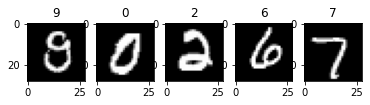

In [44]:

fig, axs = plt.subplots(1,5)
for ax in axs:
    x, t = next(train_iter)
    ax.imshow(x.squeeze(), cmap='gray')
    ax.set_title(t)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, 4, padding=1)
        self.norm3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(36 * 128, 128)
        self.norm11 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.norm12 = nn.BatchNorm1d(64)        
        self.fc3 = nn.Linear(64, 10)
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.15)
        
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.maxpool(self.norm2(F.relu(self.conv2(x))))
        x = self.dropout(self.maxpool(self.norm3(F.relu(self.conv3(x)))))
        x = x.view(-1, self.num_flat_features(x))
#         print(x.size())
        x = F.relu(self.norm11(self.fc1(x)))
        x = F.relu(self.dropout(self.norm12(self.fc2(x))))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)

In [34]:

net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.01, patience=1, mode='min')   

print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (norm11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (norm12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.15, inpl

In [35]:

train_loss_list = []
test_acc_list = []
for epoch in range(15):
    net.train()
    total_loss = 0
    for x, target in train_loader:
        x = x.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = net(x)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss
    scheduler.step(loss) 
        
    print(f"{epoch=} train_loss={100 * total_loss / total_batch}%")
    train_loss_list.append(total_loss / total_batch)
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for (x, label) in test_loader:
            x = x.to(device)
            label = label.to(device)
            output = net(x)
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    print(f"Accuracy: {100 * correct / total}%")
    test_acc_list.append(correct / total)




epoch=0 train_loss=12.435025215148926%
Accuracy: 99.23%
epoch=1 train_loss=4.069357872009277%
Accuracy: 99.28%
epoch=2 train_loss=3.018172025680542%
Accuracy: 99.29%
epoch=3 train_loss=2.3988232612609863%
Accuracy: 99.31%
epoch=4 train_loss=1.9684597253799438%
Accuracy: 99.25%
epoch=5 train_loss=1.5906914472579956%
Accuracy: 99.42%
epoch=6 train_loss=1.5720834732055664%
Accuracy: 99.16%
epoch=7 train_loss=1.05382239818573%
Accuracy: 99.29%
epoch=8 train_loss=0.6135427355766296%
Accuracy: 99.51%
epoch=9 train_loss=0.3843817114830017%
Accuracy: 99.53%
epoch=10 train_loss=0.2608542740345001%
Accuracy: 99.5%
epoch=11 train_loss=0.2489868551492691%
Accuracy: 99.54%
epoch=12 train_loss=0.1823357194662094%
Accuracy: 99.52%
epoch=13 train_loss=0.17540550231933594%
Accuracy: 99.51%
epoch=14 train_loss=0.15683384239673615%
Accuracy: 99.55%


In [ ]:
torch.save(net.state_dict(), "./mnist.pth")

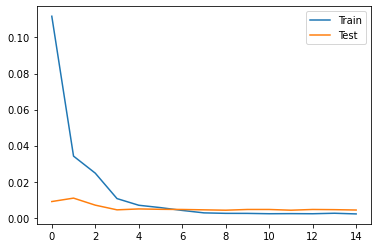

In [29]:

plt.plot(range(15), np.array(train_loss_list))
plt.plot(range(15),1 - np.array(test_acc_list))
plt.legend(['Train', 'Test'])

In [5]:
correct = 0
total = 0
net = Net().to(device)
net.load_state_dict(torch.load("./mnist.pth"))
with torch.no_grad():
    net.eval()
    for (x, label) in test_loader:
        x = x.to(device)
        label = label.to(device)
        output = net(x)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
print(f"Accuracy: {100 * correct / total}%")

Accuracy: 99.66%
